# Goodwin's oscillator toy model

This example shows how the Goodwin's Oscillator toy model can be used.

Our version of this model has five parameters and three oscillating states as described in [1].

[1] Estimating Bayes factors via thermodynamic integration and population MCMC. Ben Calderhead and Mark Girolami, 2009, Computational Statistics and Data Analysis.

In [1]:
import pints
import pints.toy
import pints.plot
import matplotlib.pyplot as plt
import numpy as np
import time

model = pints.toy.GoodwinOscillatorModel()

We can get an example set of parameters using the `suggested_parameters()` method:

In [2]:
real_parameters = model.suggested_parameters()
print(real_parameters)

[ 2.    4.    0.12  0.08  0.1 ]


In the same way, we can get a suggested set of sampling times:

In [3]:
times = model.suggested_times()

Now we can run a simulation:

In [4]:
values = model.simulate(real_parameters, times)

This gives us all we need to create a plot of current versus time:

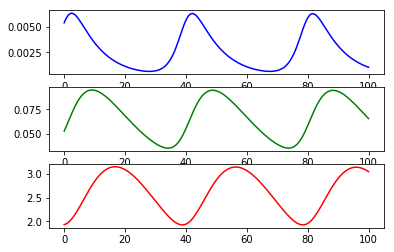

In [5]:
plt.figure()
plt.subplot(3, 1, 1)
plt.plot(times, values[:, 0], 'b')
plt.subplot(3, 1, 2)
plt.plot(times, values[:, 1], 'g')
plt.subplot(3, 1, 3)
plt.plot(times, values[:, 2], 'r')
plt.show()

Now we will add some noise to generate some fake "experimental" data and try to recover the original parameters.

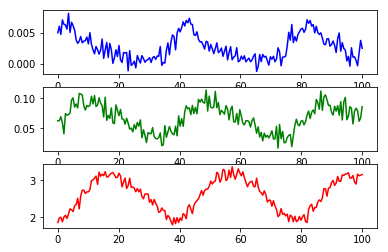

In [6]:
noise1 = 0.001
noise2 = 0.01
noise3 = 0.1
noisy_values = np.array(values, copy=True)
noisy_values[:, 0] += np.random.normal(0, noise1, len(times))
noisy_values[:, 1] += np.random.normal(0, noise2, len(times))
noisy_values[:, 2] += np.random.normal(0, noise3, len(times))

plt.figure()
plt.subplot(3, 1, 1)
plt.plot(times, noisy_values[:, 0], 'b')
plt.subplot(3, 1, 2)
plt.plot(times, noisy_values[:, 1], 'g')
plt.subplot(3, 1, 3)
plt.plot(times, noisy_values[:, 2], 'r')
plt.show()

Now we can try and infer the original parameters:

In [7]:
# Create an object with links to the model and time series
problem = pints.MultiOutputProblem(model, times, values)

# Create a log posterior
log_prior = pints.UniformLogPrior([1, 1, 0.01, 0.01, 0.01], [10, 10, 1, 1, 1])
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, [noise1, noise2, noise3])
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Run MCMC on the noisy data
x0 = [[5, 5, 0.5, 0.5, 0.5]]*3
mcmc = pints.MCMCController(log_posterior, 3, x0)
mcmc.set_max_iterations(5000)
mcmc.set_log_to_screen(False)

start = time.time()

print('Running')
chains = mcmc.run()
print('Done!')

end = time.time()
diff = end - start

Running
Done!


Print results.

In [8]:
results = pints.MCMCSummary(chains=chains, time=diff,
                            parameter_names=["k2", "k3", "m1", "m2", "m3"])
print(results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess    ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  -----  --------------
k2       3.74    2.13    1.34    1.86   3.38   5.84   7.99     1.43    7.44   0.11
k3       4.60    2.17    1.75    2.95   3.67   6.60   8.17     1.80    5.29   0.08
m1       0.23    0.19    0.07    0.09   0.12   0.39   0.61     1.11    11.40  0.16
m2       0.09    0.05    0.02    0.04   0.08   0.11   0.18     1.21    10.28  0.15
m3       0.12    0.06    0.05    0.08   0.09   0.19   0.22     1.52    6.59   0.10


Now we can inspect the resulting chains:

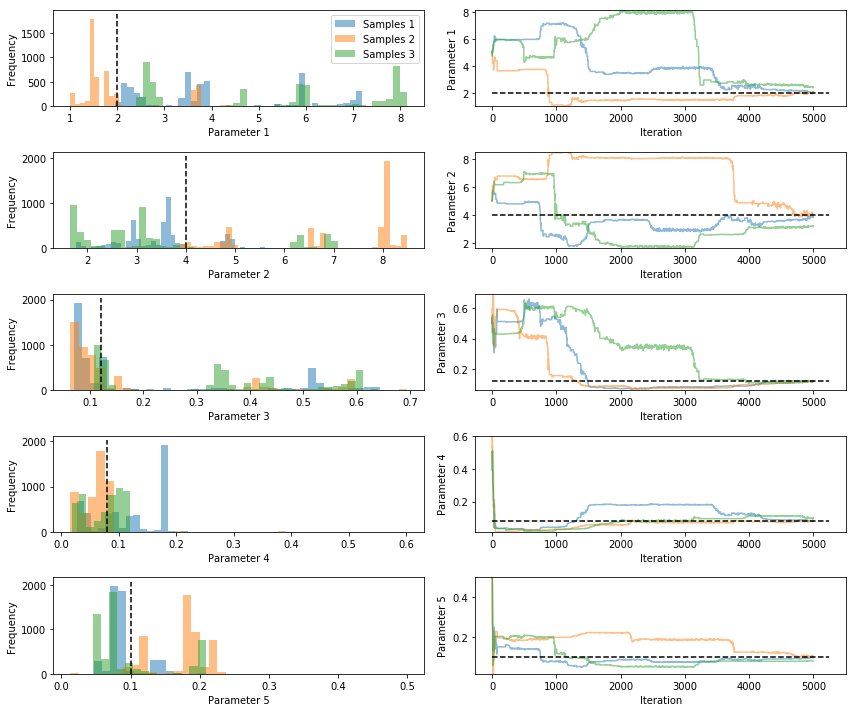

In [9]:
pints.plot.trace(chains, ref_parameters=real_parameters)
plt.show()

This is a pretty hard problem!

And what about optimisation?

In [10]:
# Fit to the noisy data
parameters = []
opt = pints.OptimisationController(log_posterior, x0[0], method=pints.XNES)
opt.set_log_to_screen(False)
parameters, fbest = opt.run()

print('')
print('            p1       p2       p3       p4       p5')
print('real  ' + ' '.join(['{: 8.4g}'.format(float(x)) for x in real_parameters]))
print('found ' + ' '.join(['{: 8.4g}'.format(x) for x in parameters]))


            p1       p2       p3       p4       p5
real         2        4     0.12     0.08      0.1
found    1.999    4.002     0.12  0.07997   0.1001


## Sampling using relativistic HMC

The Goodwin-oscillator model has sensitivities calculated by the forward sensitivities approach, so we can use samplers that use gradients (although they will be slower per iteration; although perhaps not by ESS per second!), like Relativistic HMC.

In [11]:
problem = pints.MultiOutputProblem(model, times, noisy_values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.GaussianLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0, 0, 0, 0, 0, 0, 0, 0],
    [10, 10, 1, 1, 1, 1, 1, 1]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
real_parameters1 = np.array(real_parameters.tolist() + [noise1, noise2, noise3])
xs = [
    real_parameters1 * 1.1,
    real_parameters1 * 0.9,
    real_parameters1 * 1.15,
    real_parameters1 * 1.2,
]

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 4, xs, method=pints.RelativisticMCMC)

# Add stopping criterion
mcmc.set_max_iterations(200)

# Run in parallel
mcmc.set_parallel(True)
mcmc.set_log_interval(1)


for sampler in mcmc.samplers():
    sampler.set_leapfrog_step_size([0.1, 0.5, 0.002, 0.002, 0.002, 0.0005, 0.001, 0.01])
    sampler.set_leapfrog_steps(10)

# time start
start = time.time()

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# end time
end = time.time()
diff = end - start

Running...
Using Relativistic MCMC
Generating 4 chains.
Running in parallel with 4 worker processess.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.1
1     44     0.333     0.333     0.333     0.333      0:00.7
2     84     0.5       0.5       0.25      0.5        0:01.3
3     124    0.6       0.6       0.4       0.6        0:01.8
4     164    0.5       0.667     0.5       0.5        0:02.4
5     204    0.429     0.571     0.429     0.429      0:02.9
6     244    0.5       0.5       0.5       0.375      0:03.5
7     284    0.556     0.444     0.556     0.444      0:04.0
8     324    0.6       0.4       0.5       0.4        0:04.5
9     364    0.636     0.455     0.545     0.455      0:05.1
10    404    0.583     0.5       0.583     0.5        0:05.6
11    444    0.538     0.538     0.615     0.538      0:06.2
12    484    0.571     0.571     0.571     0.571      0:06.7
13    524    0.533     0.6       0.6       0

132   5284   0.657     0.687     0.612     0.619403   1:11.2
133   5324   0.652     0.689     0.615     0.622      1:11.8
134   5364   0.654     0.684     0.618     0.618      1:12.3
135   5404   0.649635  0.686     0.620438  0.613      1:12.8
136   5444   0.652     0.688     0.623     0.609      1:13.4
137   5484   0.655     0.691     0.618705  0.604      1:13.9
138   5524   0.65      0.693     0.621     0.607      1:14.5
139   5564   0.652     0.695     0.624     0.603      1:15.0
140   5604   0.648     0.697     0.627     0.599      1:15.5
141   5644   0.65      0.692     0.629     0.594      1:16.0
142   5684   0.653     0.694     0.632     0.59       1:16.6
143   5724   0.648     0.69      0.634     0.586      1:17.1
144   5764   0.651     0.692     0.637     0.582      1:17.6
145   5804   0.653     0.687     0.639     0.578      1:18.2
146   5844   0.655     0.689     0.642     0.574      1:18.7
147   5884   0.651     0.691     0.638     0.577      1:19.2
148   5924   0.647     0

Print results.

In [12]:
results = pints.MCMCSummary(chains=chains, time=diff,
                            parameter_names=["k2", "k3", "m1", "m2", "m3",
                                             "sigma_x", "sigma_y", "sigma_z"])
print(results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
k2       2.03    0.09    1.89    1.97   2.02   2.08   2.21     1.09    42.50   0.39
k3       3.98    0.19    3.65    3.85   3.97   4.08   4.39     1.07    26.19   0.24
m1       0.12    0.00    0.11    0.12   0.12   0.12   0.13     1.08    41.92   0.39
m2       0.08    0.00    0.08    0.08   0.08   0.08   0.09     1.06    27.34   0.25
m3       0.10    0.00    0.09    0.10   0.10   0.10   0.11     1.08    23.06   0.21
sigma_x  0.00    0.00    0.00    0.00   0.00   0.00   0.00     1.00    127.58  1.19
sigma_y  0.01    0.00    0.01    0.01   0.01   0.01   0.01     1.00    117.00  1.09
sigma_z  0.10    0.01    0.09    0.10   0.10   0.10   0.13     1.01    83.57   0.78


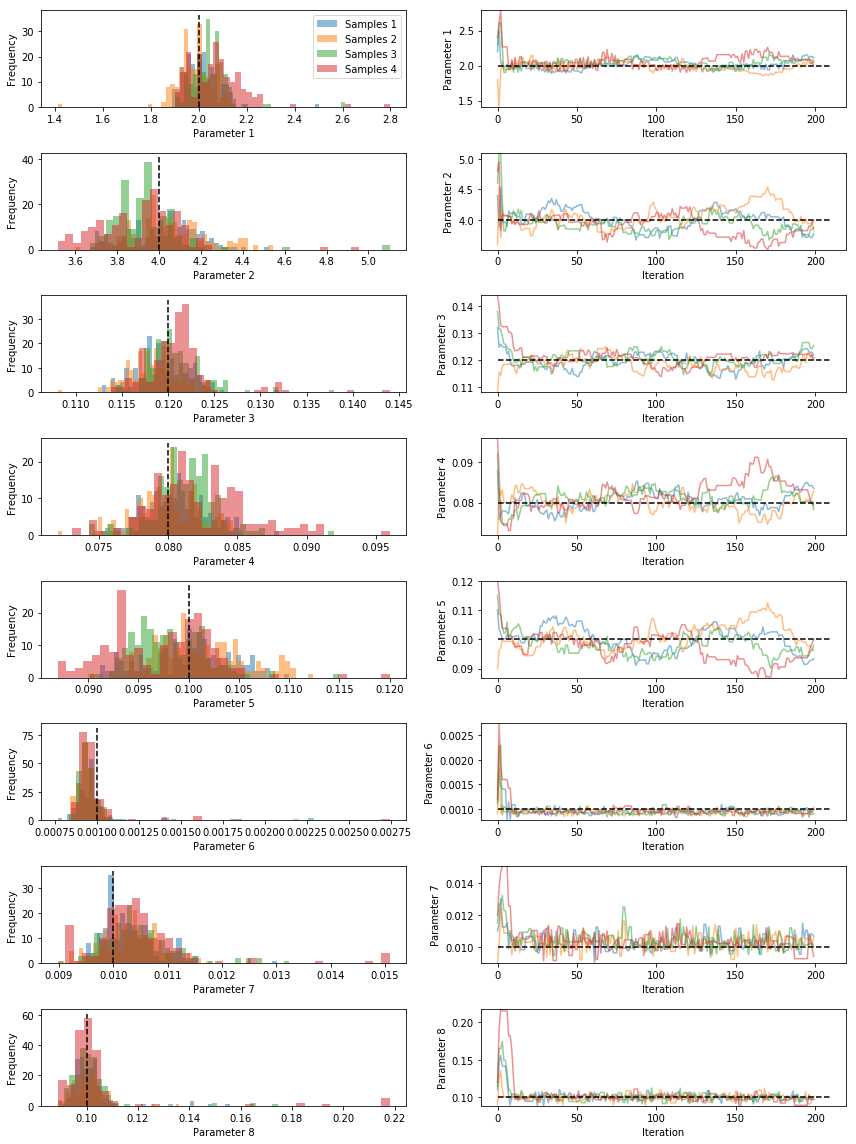

In [13]:
pints.plot.trace(chains, ref_parameters=real_parameters1)
plt.show()

Plot posterior predictive distribution.

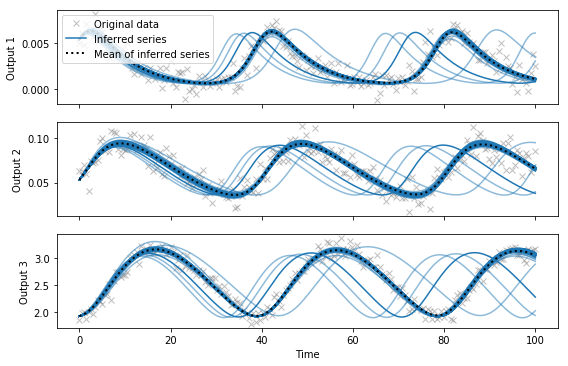

In [14]:
pints.plot.series(np.vstack(chains), problem)
plt.show()